In [1]:
%matplotlib qt

In [1]:
from extract import EEGExtract
import time
from datetime import datetime
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS, ASYNCHRONOUS
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import mne
from mne.stats import bootstrap_confidence_interval
import numpy as np
from tqdm import tqdm

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [33]:
EEG = EEGExtract('test_dataset', '088')

# In seconds
start, stop = 0, 30

data = EEG.extract('Fp1', start, stop)

print(data)

Reading channel info from test_dataset\sub-088\eeg\sub-088_task-eyesclosed_channels.tsv.
Sampling Rate: 2.00ms
(array([[ 0.00010708,  0.00012524,  0.00012949, ..., -0.00020493,
        -0.00021104, -0.00021699]]), array([0.0000e+00, 2.0000e-03, 4.0000e-03, ..., 2.9994e+01, 2.9996e+01,
       2.9998e+01]))


c:\Users\couts\Documents\Polytechnic Study and Resources\Assignments\ASP\Project AURAWAVE\backend\EEG_Extract\extract.py:19: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  self.raw = read_raw_bids(bids_path=bids_path, verbose=True)
c:\Users\couts\Documents\Polytechnic Study and Resources\Assignments\ASP\Project AURAWAVE\backend\EEG_Extract\extract.py:19: RuntimeWarning: Did not find any events.tsv associated with sub-088_task-eyesclosed.

The search_str was "test_dataset\sub-088\**\eeg\sub-088*events.tsv"
  self.raw = read_raw_bids(bids_path=bids_path, verbose=True)


In [34]:
print(EEG.raw.info['subject_info'])
print(EEG.raw.get_data(return_times=True))

{'his_id': 'sub-088', 'Gender': 'M', 'Age': '55', 'Group': 'F', 'MMSE': '24'}
(array([[ 1.07080078e-04,  1.25244133e-04,  1.29492187e-04, ...,
        -2.38183578e-04, -2.36621078e-04, -2.19628891e-04],
       [ 2.85644493e-05,  4.25292931e-05,  4.32617149e-05, ...,
        -2.23730453e-04, -2.36230453e-04, -2.23632797e-04],
       [ 6.88476944e-06,  2.07519569e-05,  2.30468788e-05, ...,
        -1.06542969e-04, -1.02343750e-04, -8.31054687e-05],
       ...,
       [-7.35839844e-05, -5.66894493e-05, -5.08789024e-05, ...,
        -1.19824203e-04, -1.20800766e-04, -1.02832016e-04],
       [-8.13964844e-05, -6.46972656e-05, -5.81054649e-05, ...,
        -1.36914047e-04, -1.36718735e-04, -1.18652328e-04],
       [-1.27490219e-04, -1.11669914e-04, -1.05664055e-04, ...,
        -9.94140625e-05, -9.87304687e-05, -7.97851562e-05]]), array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 7.94094e+02,
       7.94096e+02, 7.94098e+02]))


Create Test JSON EEG Data

In [35]:
import json


test_electrodes = ['Fp1', 'T3', 'C4', 'P4', 'O1']
test_json = {
    'eeg_data': {},
    'sample_freq': EEG.raw.info['sfreq'],
    "profile_info": {
        "Gender": EEG.raw.info['subject_info']['Gender'],
        "Age": EEG.raw.info['subject_info']['Age']
    }
}

for electrode in test_electrodes:
    test_json['eeg_data'][electrode] = EEG.extract(electrode, start, stop)[0].tolist()[0]

with open('test_3.json', 'w') as f:
    f.write(json.dumps(test_json, indent=4))

Sampling Rate: 2.00ms
Sampling Rate: 2.00ms
Sampling Rate: 2.00ms
Sampling Rate: 2.00ms
Sampling Rate: 2.00ms


Static EEG Data

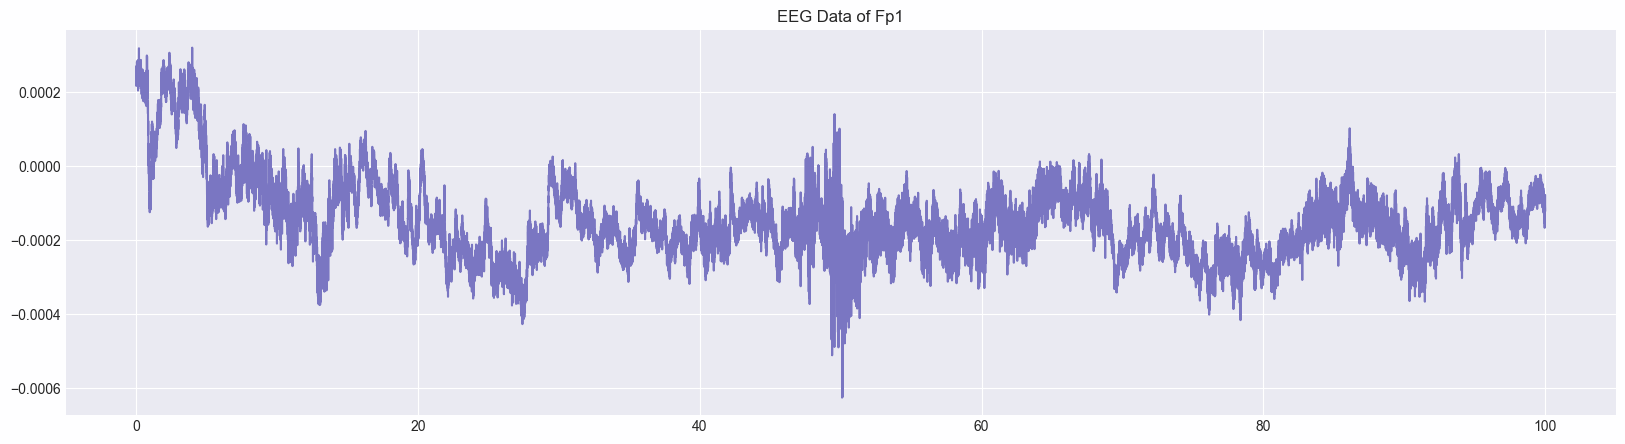

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data[1], data[0].T)
ax.set_title("EEG Data of Fp1")
plt.show()

In [1]:
fig.savefig("./images/eeg_voltage_example.png")

NameError: name 'fig' is not defined

Animated EEG Data of Fp1 Signal (Simulate real-time data)

In [27]:
%matplotlib qt

x = []
y = []

fig, ax = plt.subplots()

def animate(i):
    pt = data[0].T[i]
    x.append(i * EEG.sampling_rate / 1000)
    y.append(pt)

    ax.clear()
    ax.plot(x, y)
    ax.set_ylim([-2e-5, 1.3e-4])

anim = FuncAnimation(fig, animate, frames=len(data[1]), interval=1, repeat=False)
plt.show()

Animated EEG Data of Fp1 Signal with 0.5s Window Plot

In [34]:
%matplotlib qt

x = []
y = []
# In Seconds
WINDOW_TIME = 0.5

fig, ax = plt.subplots()

def animate(i):
    t = i * EEG.sampling_rate / 1000
    t_min = 0 if t < WINDOW_TIME else t - WINDOW_TIME
    t_max = WINDOW_TIME if t < WINDOW_TIME else t
    pt = data[0].T[i]

    x.append(t)
    y.append(pt)

    ax.clear()
    ax.plot(x, y)
    ax.set_xlim([t_min, t_max])

    return ax

anim = FuncAnimation(fig, animate, frames=len(data[1]), interval=2e-3, repeat=False)
fig.suptitle("EEG Simulation (Fp1)", fontsize=13)

Text(0.5, 0.98, 'EEG Simulation (Fp1)')

In [12]:
# Save previous animation
x = []
y = []
writervideo = animation.FFMpegWriter(fps=24, bitrate=4500)
anim.save('anims/test.mp4', writer=writervideo)

In [35]:
BUCKET = "eeg_data"
ORG = "AurawaveData"
TOKEN = "Qgo8yHYFH6RV_Q7iWU3JYxO2CsuTgZRn_IkIje31vrDrGisFS3b2wdrl3sO-Lqmizvs87IPJoHebjaJL8-lb0Q=="
# Store the URL of your InfluxDB instance
URL="http://localhost:8086"

def influx_main():
    client = influxdb_client.InfluxDBClient(url=URL, org=ORG, token=TOKEN)
    write_eeg_data(client)

def write_eeg_data(client: influxdb_client.InfluxDBClient):
    write_api = client.write_api(write_options=ASYNCHRONOUS)

    for i, t in enumerate(data[1]):
        point = [
            {
                "time": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S.%f"),
                "measurement": "eeg_measurement",
                "tags": {
                    "type": "eeg",
                },
                "fields": {
                    "value": data[0].T[i][0] * 1e6
                }
            }
        ]
        write_api.write(bucket=BUCKET, org=ORG, record=point)

        print(f"Read point at time: {t * 1e3}ms with voltage: {data[0].T[i][0] * 1e6}uV")
        time.sleep(EEG.sampling_rate / 1e3)

influx_main()

Read point at time: 0.0ms with voltage: -189.89256286621094uV
Read point at time: 2.0ms with voltage: -180.4199066162109uV
Read point at time: 4.0ms with voltage: -166.99217224121094uV
Read point at time: 6.0ms with voltage: -160.2050628662109uV
Read point at time: 8.0ms with voltage: -159.32615661621094uV
Read point at time: 10.0ms with voltage: -154.29685974121094uV
Read point at time: 12.0ms with voltage: -171.0937347412109uV
Read point at time: 14.0ms with voltage: -183.54490661621094uV
Read point at time: 16.0ms with voltage: -181.54295349121094uV
Read point at time: 18.0ms with voltage: -175.92771911621094uV
Read point at time: 20.0ms with voltage: -189.69725036621094uV
Read point at time: 22.0ms with voltage: -184.22850036621094uV
Read point at time: 24.0ms with voltage: -169.3359222412109uV
Read point at time: 26.0ms with voltage: -161.37693786621094uV
Read point at time: 28.0ms with voltage: -178.36912536621094uV
Read point at time: 30.0ms with voltage: -175.92771911621094uV
R

KeyboardInterrupt: 

Effective window size : 4.096 (s)


c:\Users\couts\Documents\Polytechnic Study and Resources\Assignments\ASP\Project AURAWAVE\backend\EEG_Extract\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


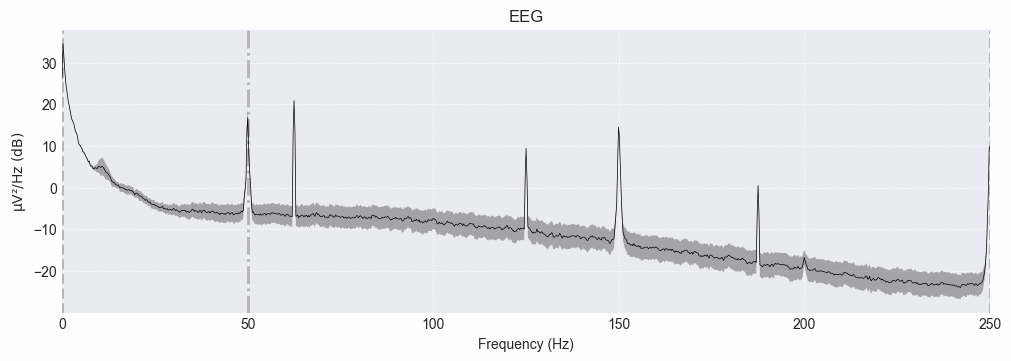

In [44]:
fig = EEG.raw.compute_psd().plot(average=True)
plt.show()

In [49]:
fig.savefig("./images/psd_example.png")

Split waveform into 5 frequency bands

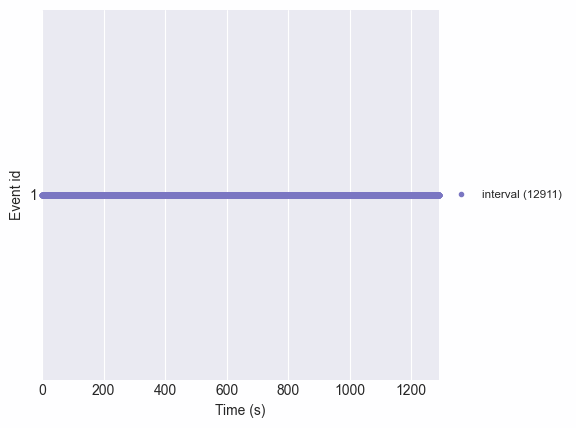

Not setting metadata
12911 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12911 events and 1101 original time points ...
22 bad epochs dropped


In [24]:
# Create events

events = mne.make_fixed_length_events(EEG.raw, start=0, stop=None, duration=0.1, first_samp=True)
fig = mne.viz.plot_events(events, event_id={"interval": 1}, sfreq=EEG.sampling_freq, first_samp=True)

# Create Epochs
epochs = mne.Epochs(
    EEG.raw,
    events,
    event_id={"interval": 1},
    tmin=-0.2,
    tmax=2,
    baseline=None,
    preload=True
)

In [101]:
EEG.raw.get_data()

array([[-1.59312925e-30, -5.47992300e-18, -1.11155577e-17, ...,
        -3.33356774e-18, -1.66656036e-18, -9.70668692e-32],
       [-2.56996092e-30, -5.61559823e-18, -1.12083411e-17, ...,
        -4.10695973e-18, -2.02795781e-18, -4.65304675e-31],
       [-1.01072803e-30, -7.72606292e-18, -1.51302501e-17, ...,
        -5.45081556e-18, -2.78906944e-18, -2.51141265e-31],
       ...,
       [-1.38358807e-30, -4.77286122e-18, -9.49419174e-18, ...,
         1.89407694e-19,  1.44634295e-19, -1.47295122e-30],
       [-1.88895209e-30, -5.38530618e-18, -1.06009367e-17, ...,
        -4.86755931e-18, -2.42372649e-18, -5.42341872e-31],
       [-1.15555797e-30, -8.05633790e-18, -1.56930170e-17, ...,
        -4.90156136e-18, -2.21829706e-18, -1.15863945e-30]])

In [15]:
iter_freqs = [("Delta", 1, 3), ("Theta", 4, 7), ("Gamma", 30, 100), ("Beta", 13, 30), ("Alpha", 8, 12)]
freq_map = []

for band, l_freq, h_freq in iter_freqs:
    raw = EEG.raw.copy()

    filtered = raw.filter(l_freq, h_freq, l_trans_bandwidth=1, h_trans_bandwidth=1)

    # # Create events
    # events = mne.make_fixed_length_events(filtered, start=0, stop=None, duration=0.1, first_samp=True)
    # # fig = mne.viz.plot_events(events, event_id={"interval": 1}, sfreq=EEG.sampling_freq, first_samp=True)

    # # Create Epochs
    # epochs = mne.Epochs(
    #     filtered,
    #     events,
    #     event_id={"interval": 1},
    #     tmin=-0.2,
    #     tmax=3,
    #     baseline=None,
    #     preload=True
    # )

    # epochs.apply_hilbert(envelope=True)

    # Average epochs (over all events) for each channel
    freq_map.append(((band, l_freq, h_freq), filtered))
    # print(epochs.average().data.shape)

    # del epochs
    # del events
    


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Filter length: 1651 samples (3.302 s)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Upper passband edge

[Max GFP]
Delta (1-3Hz): 1.3412860243612817e-15
Theta (4-7Hz): 5.5200069226610674e-17
Gamma (30-100Hz): 2.4218250494261554e-11
Beta (13-30Hz): 1.1205713884128301e-13
Alpha (8-12Hz): 7.019375383477763e-14


Text(0.5, 1.0, 'EEG GFP by Frequency Bands')

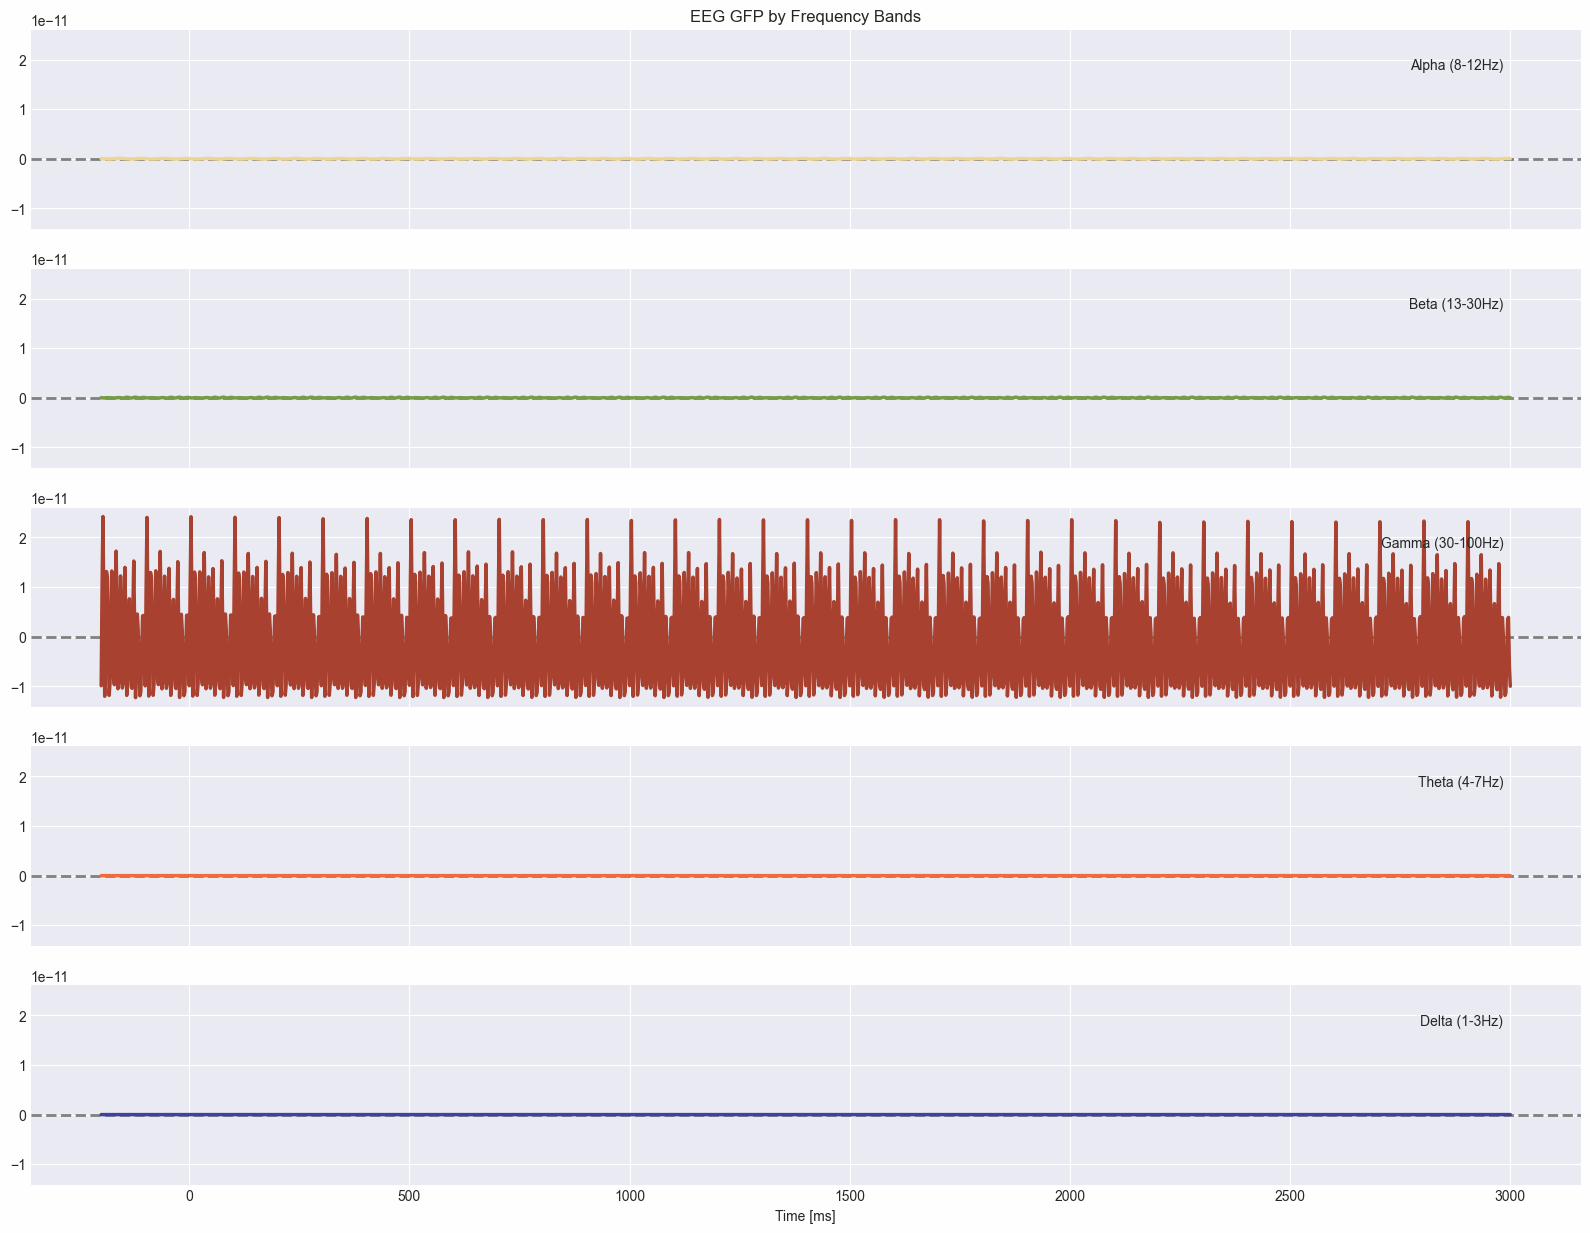

In [14]:
# Using Hilbert Transform and 

fig, axes = plt.subplots(len(iter_freqs), 1, figsize=(20, 15), sharex=True, sharey=True)

colours = ["#f0d592", "#779c47", "#a84130", "#ed6b3c", "#3e439c"]

print("[Max GFP]")
for ((band, l_freq, h_freq), average), colour, ax in zip(freq_map, colours[::-1], axes.ravel()[::-1]):
    times = average.times * 1e3 # Convert to ms
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0), verbose=False)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ax.plot(times, gfp, label=band, color=colour, linewidth=2.5)
    ax.annotate(
        "%s (%d-%dHz)" % (band, l_freq, h_freq),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    # ax.set_ylim(0, 1.25e-7)

    print(f"{band} ({l_freq}-{h_freq}Hz): {np.max(gfp)}")

axes.ravel()[-1].set_xlabel("Time [ms]")
axes[0].set_title("EEG GFP by Frequency Bands")

[Max GFP]
Applying baseline correction (mode: mean)
Delta (1-3Hz): 2.1861907746312926e-07
Applying baseline correction (mode: mean)
Theta (4-7Hz): 2.753491754715473e-08
Applying baseline correction (mode: mean)
Gamma (30-100Hz): 1.5666977115813916e-06
Applying baseline correction (mode: mean)
Beta (13-30Hz): 1.0551799719538735e-07
Applying baseline correction (mode: mean)
Alpha (8-12Hz): 7.956888268353925e-09


Text(0.5, 1.0, 'EEG GFP by Frequency Bands')

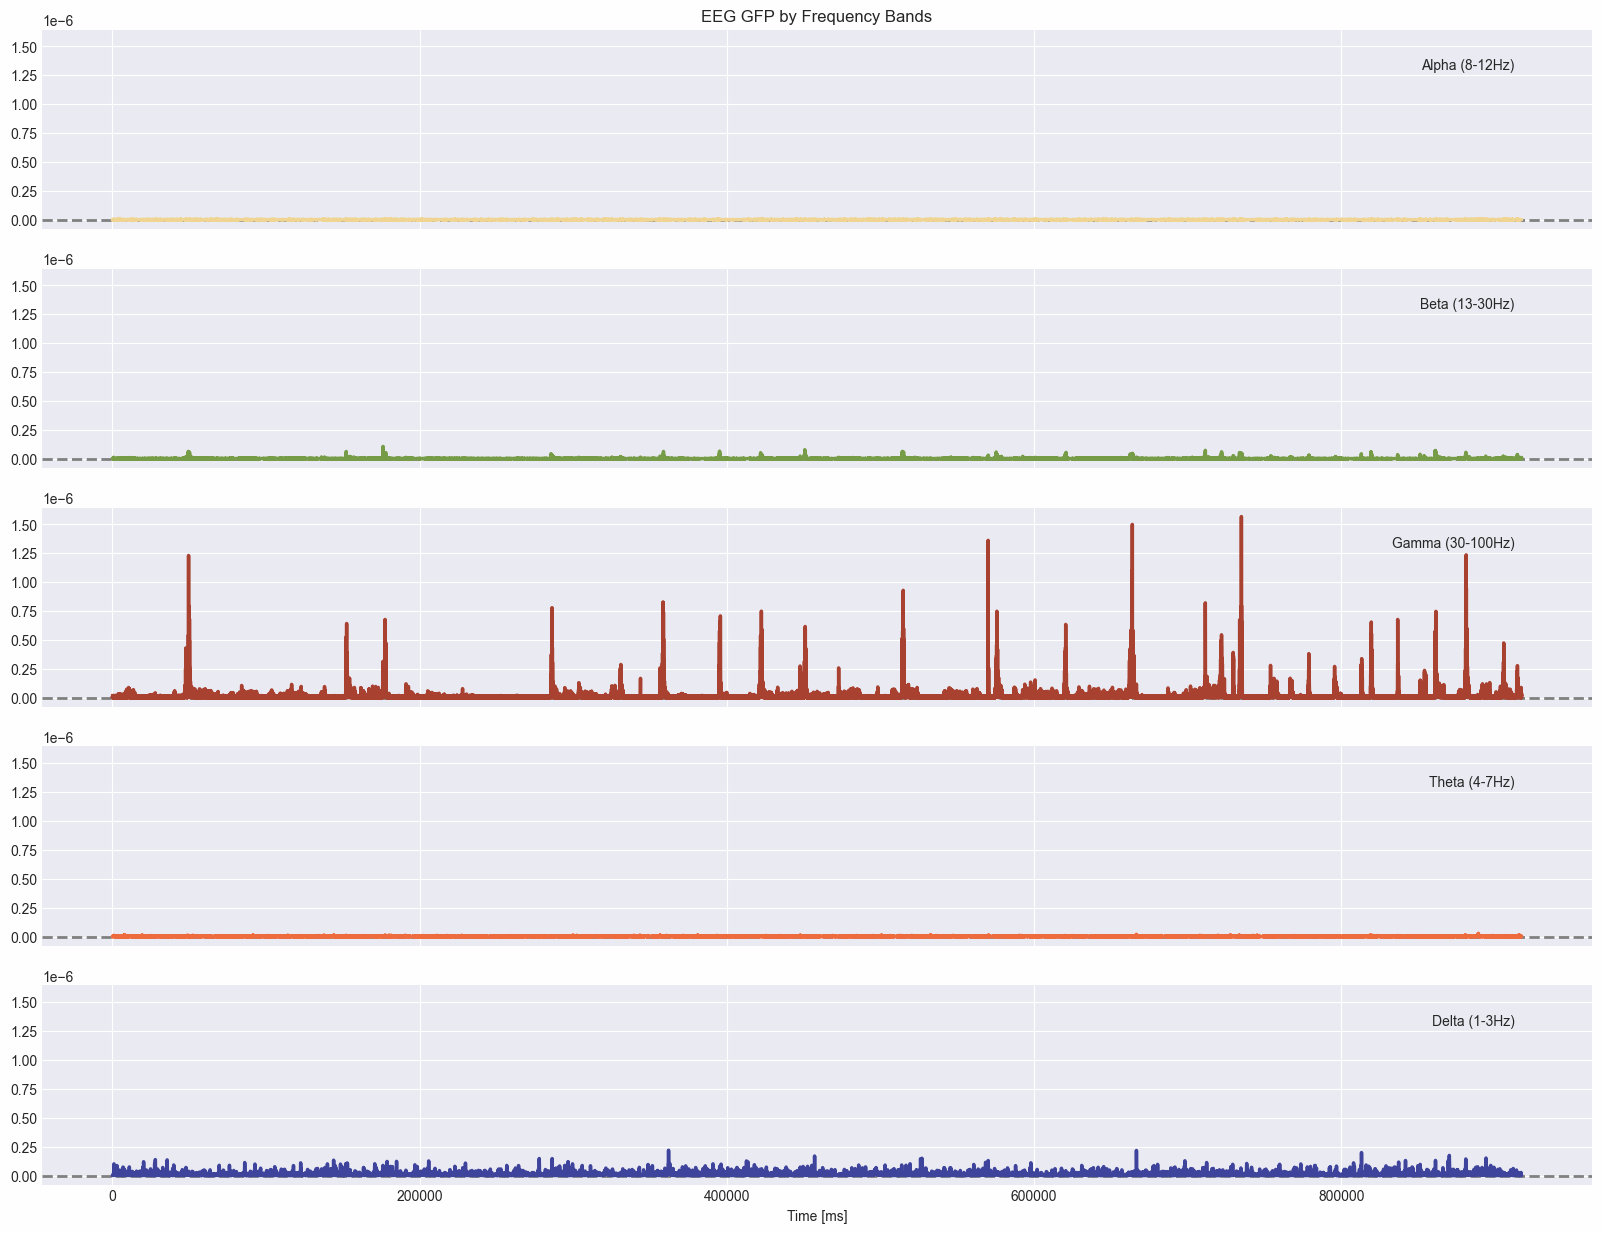

In [21]:
fig, axes = plt.subplots(len(iter_freqs), 1, figsize=(20, 15), sharex=True, sharey=True)

colours = ["#f0d592", "#779c47", "#a84130", "#ed6b3c", "#3e439c"]

gfp_map = {}

print("[Max GFP]")
for ((band, l_freq, h_freq), raw), colour, ax in zip(freq_map, colours[::-1], axes.ravel()[::-1]):
    times = raw[:, :][1] * 1e3 # Convert to ms
    gfp = np.sum(raw[:, :][0] ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0), verbose=False)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ax.plot(times, gfp, label=band, color=colour, linewidth=2.5)
    ax.annotate(
        "%s (%d-%dHz)" % (band, l_freq, h_freq),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    # ax.set_xlim([-1000, 3000])
    # ax.set_ylim(0, 1.25e-7)

    gfp_map[band] =  gfp

    print(f"{band} ({l_freq}-{h_freq}Hz): {np.max(gfp)}")

axes.ravel()[-1].set_xlabel("Time [ms]")
axes[0].set_title("EEG GFP by Frequency Bands")

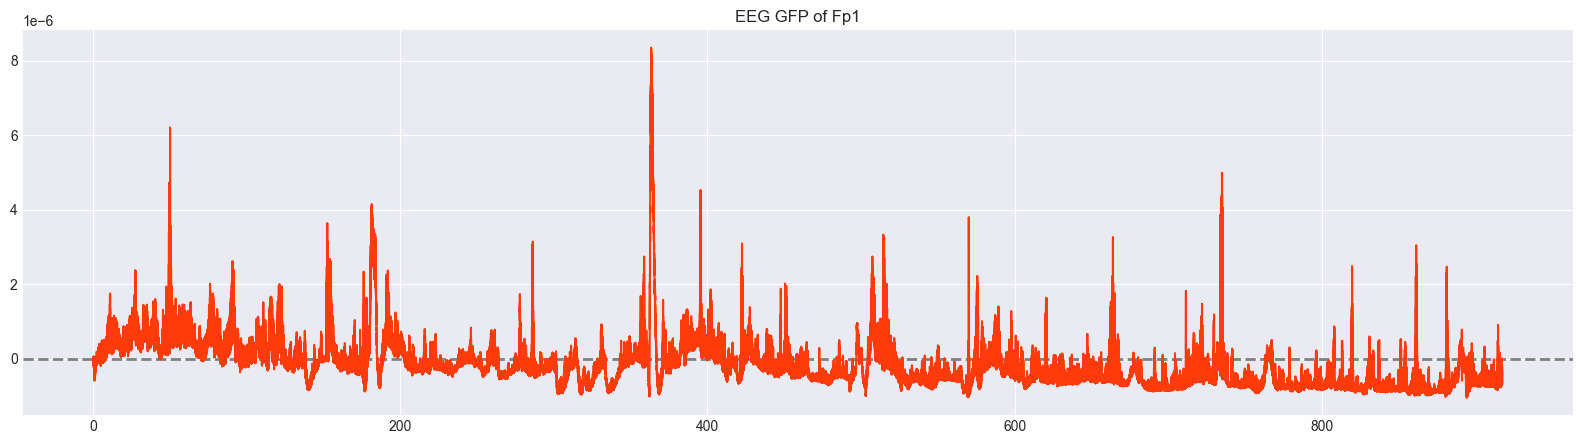

In [23]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 5))

times = EEG.raw[:, :][1]
gfp = np.sum(EEG.raw[:, :][0] ** 2, axis=0)
gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0), verbose=False)
ax.axhline(0, linestyle="--", color="grey", linewidth=2)

ax.plot(times, gfp, color='#ff3b0c')
ax.set_title("EEG GFP of Fp1")
plt.show()

Simualte Live Data from Raspi to InfluxDB

In [16]:
BUCKET = "eeg_data"
ORG = "AurawaveData"
TOKEN = "Qgo8yHYFH6RV_Q7iWU3JYxO2CsuTgZRn_IkIje31vrDrGisFS3b2wdrl3sO-Lqmizvs87IPJoHebjaJL8-lb0Q=="
# Store the URL of your InfluxDB instance
URL="http://localhost:8086"

def influx_main():
    client = influxdb_client.InfluxDBClient(url=URL, org=ORG, token=TOKEN)
    write_eeg_data(client)
    
def write_eeg_data(client: influxdb_client.InfluxDBClient):
    write_api = client.write_api(write_options=SYNCHRONOUS)

    for i, t in enumerate(data[1]):
        banded_point = [
            {
                "time": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S.%f"),
                "measurement": "eeg_measurement_banded",
                "tags": {
                    "type": "eeg",
                },
                "fields": {
                    "alpha": gfp_map['Alpha'][i] * 1e3,
                    'beta': gfp_map['Beta'][i] * 1e3,
                    'gamma': gfp_map['Gamma'][i] * 1e3,
                    'theta': gfp_map['Theta'][i] * 1e3,
                    'delta': gfp_map['Delta'][i] * 1e3
                }
            }
        ]
        write_api.write(bucket=BUCKET, org=ORG, record=banded_point)

        single_point = [
            {
                "time": datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S.%f"),
                "measurement": "eeg_measurement",
                "tags": {
                    "type": "eeg",
                },
                "fields": {
                    "value": data[0].T[i][0] * 1e6
                }
            }
        ]
        write_api.write(bucket=BUCKET, org=ORG, record=single_point)

        print(f"Wrote point at time: {t * 1e3}ms")
        time.sleep(EEG.sampling_rate / 1e3)

influx_main()

Wrote point at time: 0.0ms
Wrote point at time: 2.0ms
Wrote point at time: 4.0ms
Wrote point at time: 6.0ms
Wrote point at time: 8.0ms
Wrote point at time: 10.0ms
Wrote point at time: 12.0ms
Wrote point at time: 14.0ms
Wrote point at time: 16.0ms
Wrote point at time: 18.0ms
Wrote point at time: 20.0ms
Wrote point at time: 22.0ms
Wrote point at time: 24.0ms
Wrote point at time: 26.0ms
Wrote point at time: 28.0ms
Wrote point at time: 30.0ms
Wrote point at time: 32.0ms
Wrote point at time: 34.0ms
Wrote point at time: 36.0ms
Wrote point at time: 38.0ms
Wrote point at time: 40.0ms
Wrote point at time: 42.0ms
Wrote point at time: 44.0ms
Wrote point at time: 46.0ms
Wrote point at time: 48.0ms
Wrote point at time: 50.0ms
Wrote point at time: 52.0ms
Wrote point at time: 54.0ms
Wrote point at time: 56.0ms
Wrote point at time: 58.0ms
Wrote point at time: 60.0ms
Wrote point at time: 62.0ms
Wrote point at time: 64.0ms
Wrote point at time: 66.0ms
Wrote point at time: 68.0ms
Wrote point at time: 70.0